# Exploratory Data Analysis of FWI Weather Forcings

## Introduction
The Fire Weather Index (FWI) is a meteorologically based index used worldwide to estimate fire danger. It consists of different components that account for the effects of fuel moisture and wind on fire behaviour and spread. The higher the FWI, the more favorable the meteorological conditions to trigger a wildfire. This indicator can help shape long-term tourist strategy and to plan future investments under a changing climate.

The [`esowc/wildfire-forecasting`](https://github.com/esowc/wildfire-forecasting) project intends to reproduce the Fire Forecasting capabilities of GEFF using Deep Learning and develop further improvements in accuracy, geography and time scale through inclusion of additional variables or optimisation of model architecture & hyperparameters. 

In this notebook we explore the weather forcings that are used for calculating the FWI.
```
* t2     -    Temperature at 2m (K)
* tp     -    Total Precipitation accumulated over the previous 24 hours (mm)
* rh     -    Relative Humidity (%)
* wspeed -    Windspeed (m/s)
```

To run this notebook, make sure you have the `wildfire-dl` `conda` environment activated. Instructions for setting up the environment are available in the project [`README`](https://github.com/esowc/wildfire-forecasting/blob/master/README.md).

## Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [1]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

## Getting the data

We first obtain a sample dataset (~`1.5GB` in size). This data is stored on a publicly accessible GCP bucket at `gs://deepfwi-mini-sample` and is downloaded into `data/mini_sample/`

Navigate to the root of the repo

In [2]:
os.chdir('../..')

Getting the data from GCP bucket,

In [3]:
# Uncomment the code below to download data from GCP
# !mkdir data/mini_sample -p
# !gsutil -q cp -r 'gs://deepfwi-mini-sample/*' data/mini_sample

Sample of files we just fetched,

In [4]:
files = glob('data/mini_sample/fwi-forcings/*')
files[:4]

['data/mini_sample/fwi-forcings/ECMWF_FO_20191201_1200_hr_tp.nc',
 'data/mini_sample/fwi-forcings/ECMWF_FO_20191204_1200_hr_t2.nc',
 'data/mini_sample/fwi-forcings/ECMWF_FO_20191203_1200_hr_tp.nc',
 'data/mini_sample/fwi-forcings/ECMWF_FO_20191201_1200_hr_rh.nc']

## Overview

Each file contains 10 days of data.

Selecting only the day zero values. `isel` method allows selecting data by index slice.

In [5]:
def preprocess(d):
    return d.isel(time=slice(0,1))

Combining multiple files into single dataarray.

In [6]:
data = xr.open_mfdataset(files, preprocess=preprocess).load()

Taking a look.

In [7]:
print(data)

<xarray.Dataset>
Dimensions:  (lat: 2560, lon: 5120, time: 4)
Coordinates:
  * lat      (lat) float32 89.94619 89.87648 89.80636 ... -89.87648 -89.94619
  * lon      (lon) float32 0.0 0.0703125 0.140625 ... 359.85938 359.9297
  * time     (time) datetime64[ns] 2019-12-01 2019-12-02 2019-12-03 2019-12-04
Data variables:
    rh       (time, lat, lon) float32 81.024506 81.02401 ... 71.83352 71.83365
    t2       (time, lat, lon) float32 248.70111 248.70122 ... 242.19002 242.1901
    tp       (time, lat, lon) float32 0.045776367 0.045776367 ... 0.0 0.0
    wspeed   (time, lat, lon) float32 4.868662 4.868764 ... 6.3979115 6.3982606
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Sat Jun 06 02:07:12 2020: cdo --silent -select,name=tp...
    Reference date:    20191201
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators v

**Pixel resolution**: *2560x5120*<br>
**Longitude resolution**: 0.0703125<br>
**Latitude resolution**: 0.06971<br>

Time span of the data,

In [8]:
d_range = [str(v.astype('datetime64[D]')) for v in data.time.values]
f"From {d_range[0]} to {d_range[-1]}"

'From 2019-12-01 to 2019-12-04'

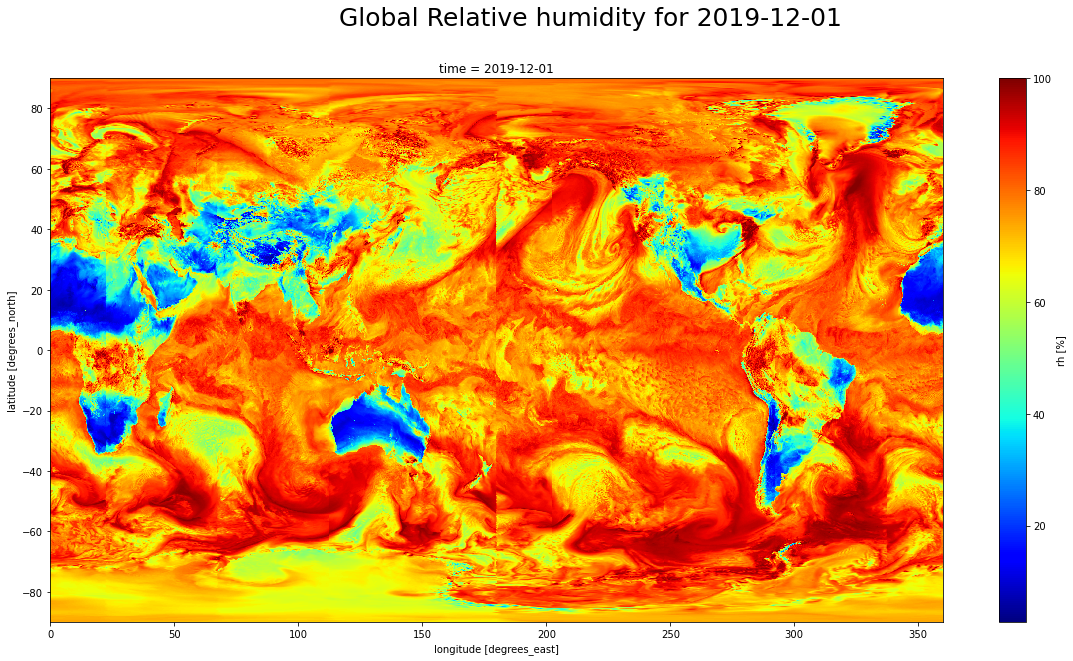

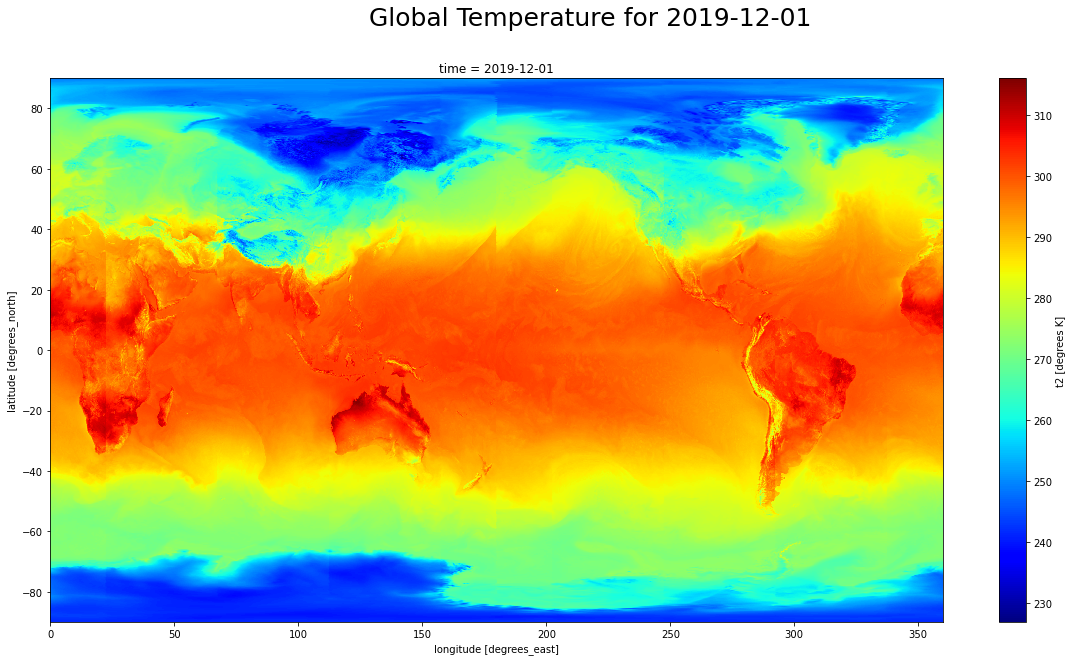

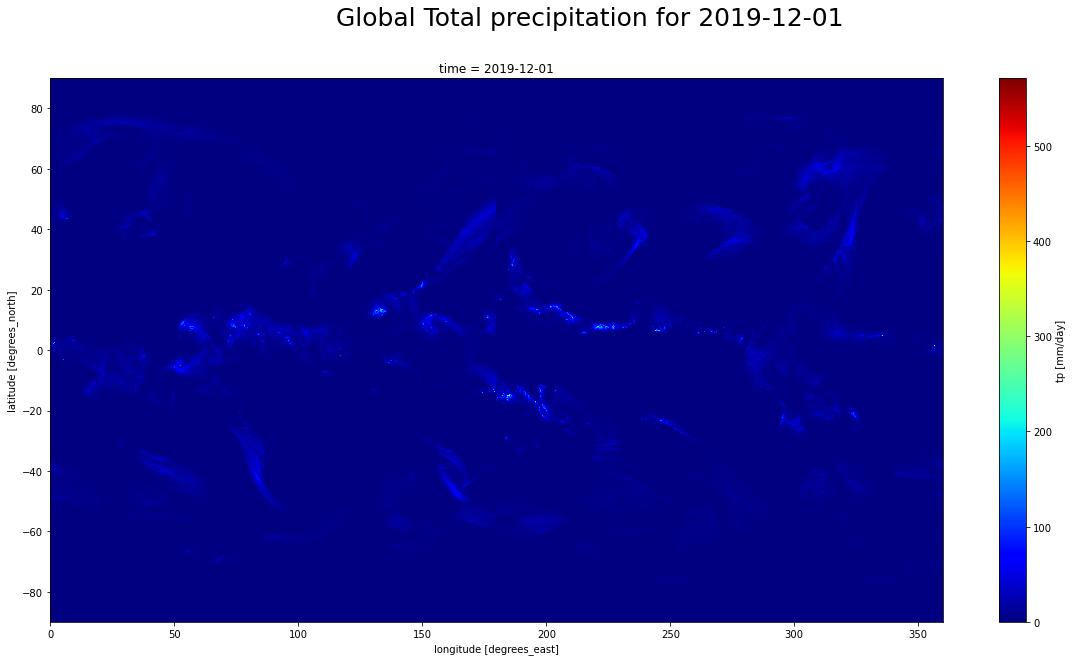

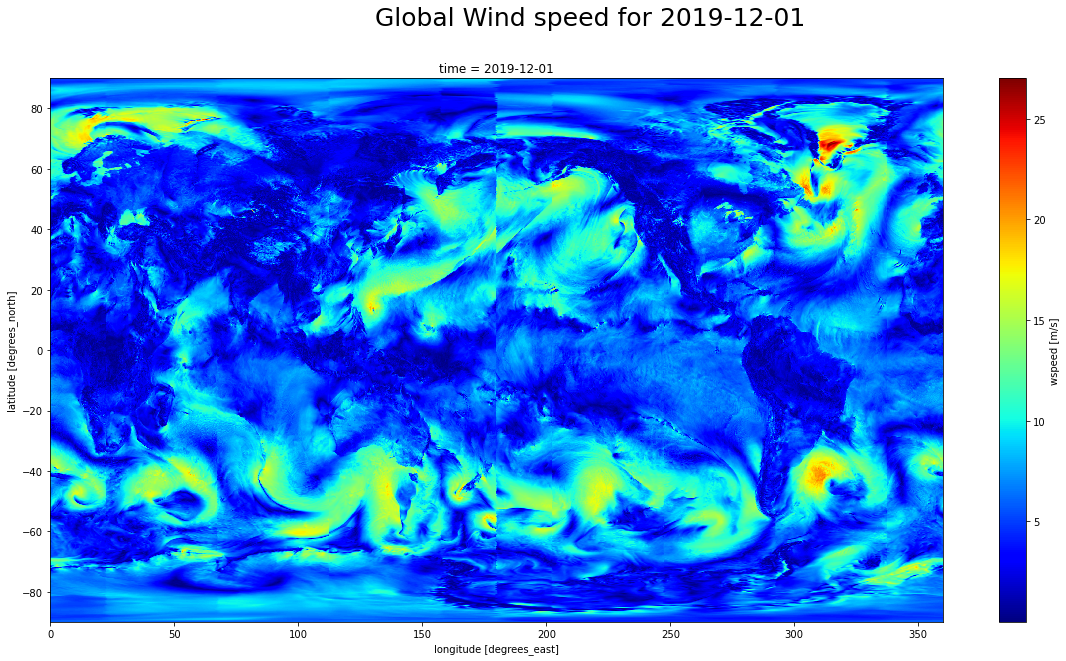

In [9]:
var_list =['Relative humidity', 'Temperature', 'Total precipitation', 'Wind speed']
for i in range(4):
    plt.figure(figsize = (20,10)).suptitle(f'Global {var_list[i]} for {d_range[0]}', fontsize=25)
    data[list(data.data_vars)[i]][0].plot(cmap='jet')
    plt.show()

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [10]:
for i in data.data_vars:
    print(f"{i:<6} {np.isnan(data[i][0].values).any()}")

rh     False
t2     False
tp     False
wspeed False


## Overall statistics

In [11]:
def stats(x):
    # For xarray matrices
    tmp = x.mean(skipna=True).values
    print('Mean'.ljust(10), tmp)
    print('MAD'.ljust(10), abs(x-tmp).mean(skipna=True).values)
    print('Variance'.ljust(10), x.var(skipna=True).values)
    print('Minimum'.ljust(10), x.min(skipna=True).values)
    print('Maximum'.ljust(10), x.max(skipna=True).values)

### Relative humidity

In [12]:
stats(data.rh)

Mean       73.47585
MAD        11.327083
Variance   257.19336
Minimum    1.8521714
Maximum    100.018715


### Temperature

In [13]:
stats(data.t2)

Mean       278.76895
MAD        16.457268
Variance   372.6067
Minimum    220.06276
Maximum    316.53644


### Total precipitation

In [14]:
stats(data.tp)

Mean       2.4750032
MAD        3.1577294
Variance   47.057457
Minimum    0.0
Maximum    677.8625


### Wind speed

In [15]:
stats(data.wspeed)

Mean       6.541168
MAD        2.9711173
Variance   13.794974
Minimum    0.0004310608
Maximum    42.327652


## Frequency distribution

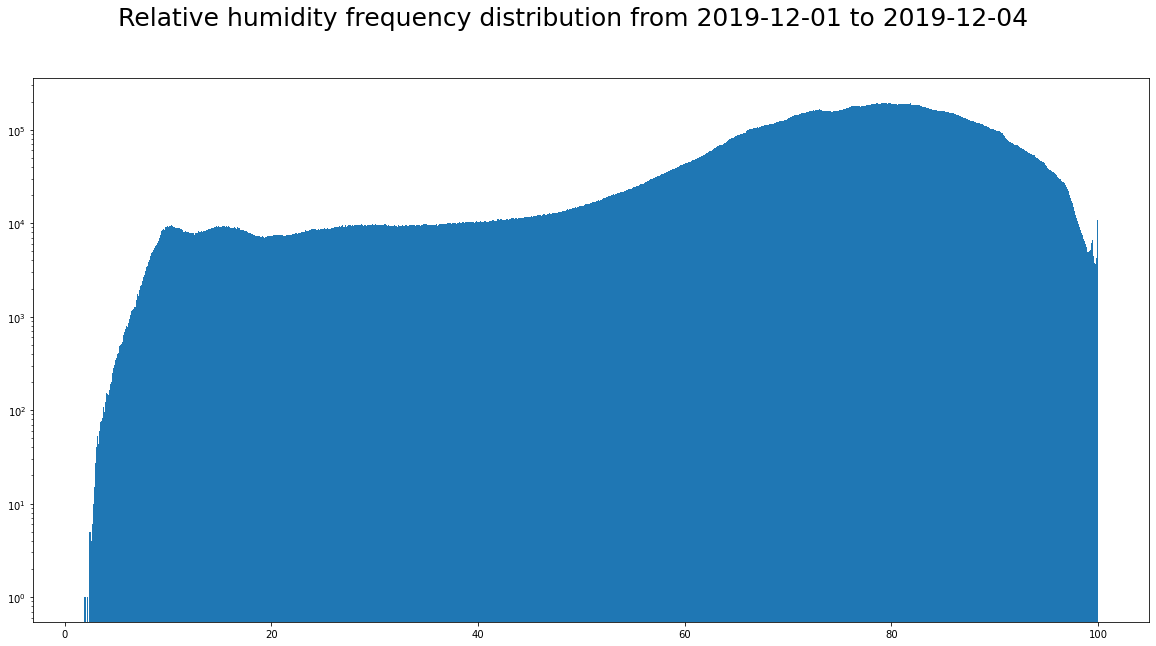

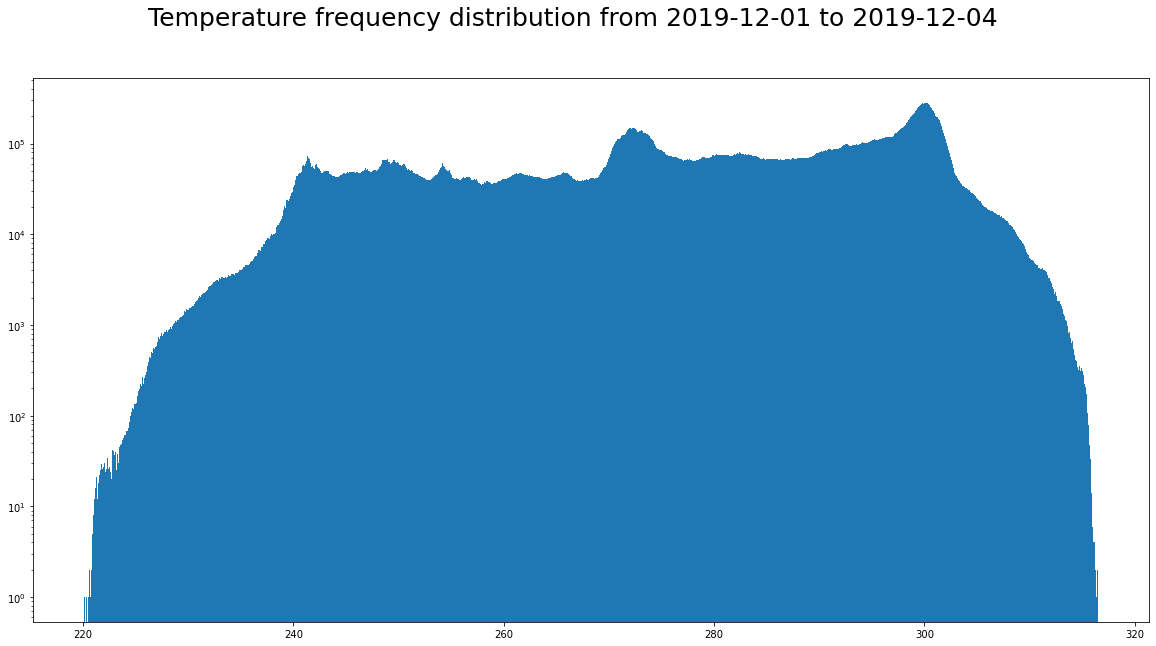

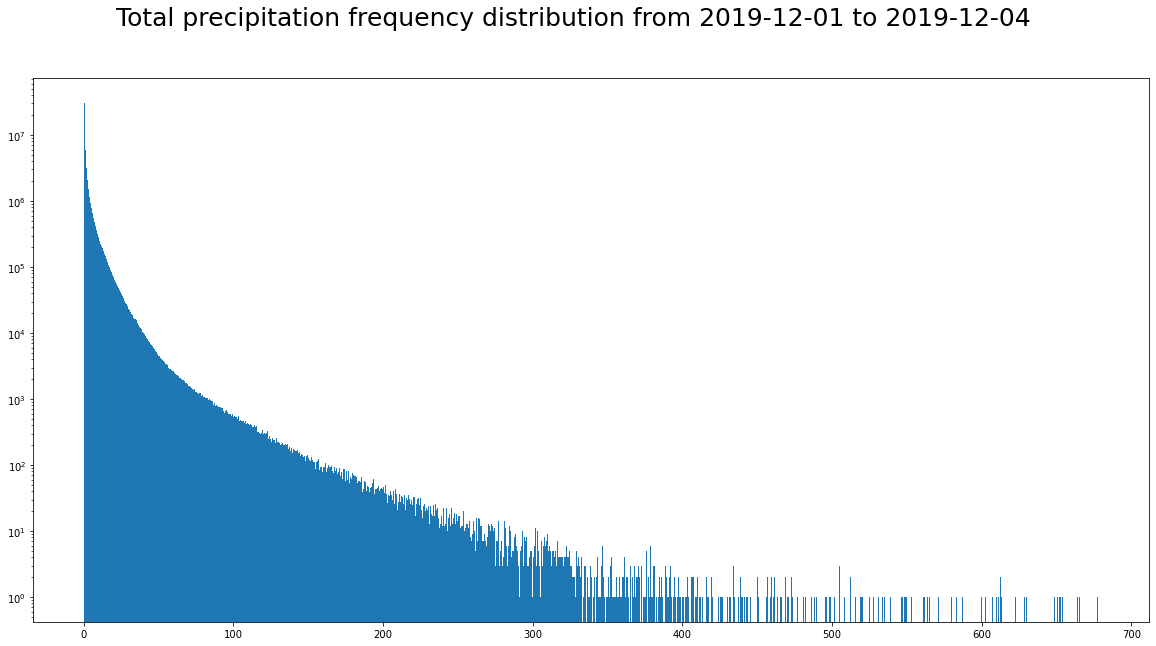

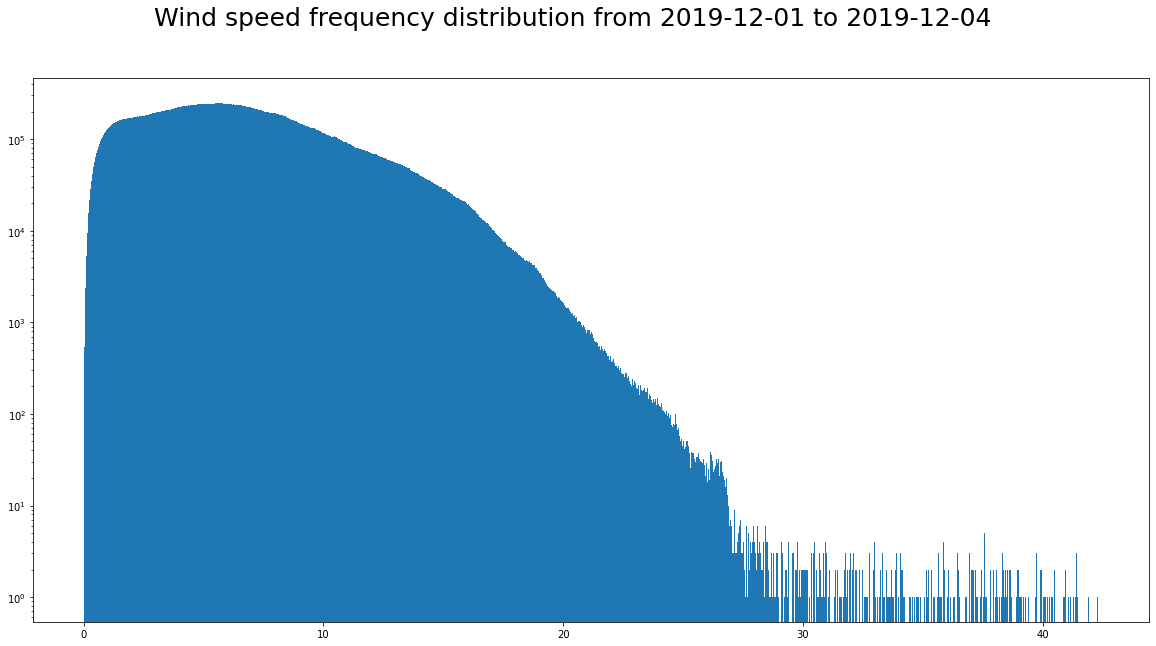

In [16]:
var_list =['Relative humidity', 'Temperature', 'Total precipitation', 'Wind speed']
for i in range(4):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution from {min(d_range)} to {max(d_range)}', fontsize=25)
    plt.hist(data[list(data.data_vars)[i]].values.flatten(), bins=1000, cumulative=False, log=True);
    plt.show()